# Evaluate Pre-Trained Model

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Batch

plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = 18


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Add base path to the system path
base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if not base_path in sys.path:
    sys.path.append(base_path)
print(base_path)

/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src


In [5]:
# Import code from other directories
from data.data import scale_3d_poses, scale_2d_positions
from data.visualizations import make_3d_figax, animate_3d_pose, plot_3d_pose
from model.model_builder import build_tennis_embedder
from model.data import TennisDataset, build_human_pose_edge_index
from train.PreTrainer import my_collate_fn, PreTrainer

In [6]:
# Create directory to save figures
figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)

## Load Model

In [7]:
# Define configuration path
model_config_path = os.path.join(base_path, "model", "configs", "default.yaml")

# Define model weights path
model_weights_path = os.path.join(base_path, os.pardir, "models", "best_model.pth")

In [8]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50
train_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/train'
val_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/val'
test_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/test'

In [9]:
# Trainer Setup
trainer = PreTrainer(
    batch_size=BATCH_SIZE,
    lr=LR,
    epochs=EPOCHS,
    train_path=train_path,
    val_path=val_path,
    model_config_path=model_config_path,
    model_save_path='trained_models'
)

Using device: cuda


In [11]:
model_weights_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/trained_models/best_model.pth"
trainer.load_pretrained_model(model_weights_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/trained_models/best_model.pth


Test Loss: 0.03309369397660097


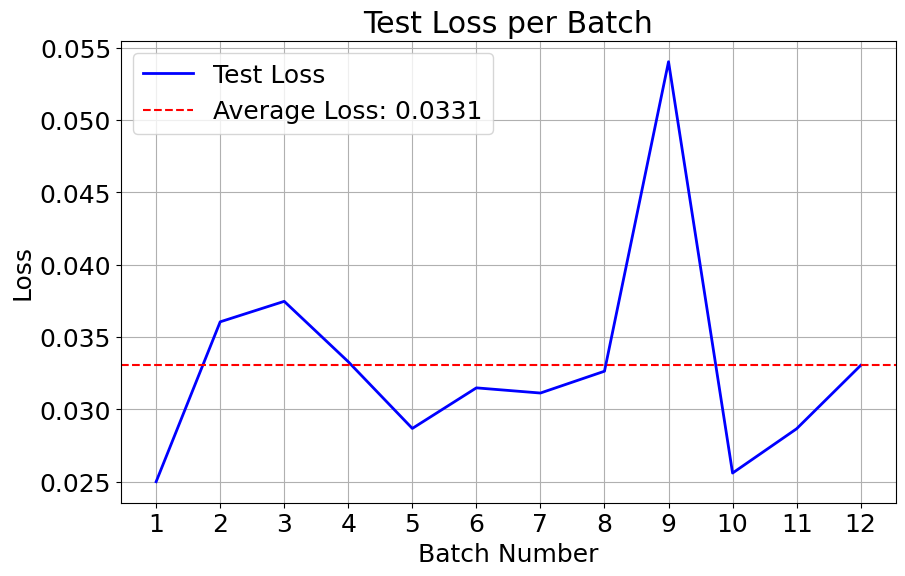

In [12]:
trainer.test_trained_model(test_path)

## Evaluate Model

### Auxiliary Functions

In [ ]:
# Find max sequence length
max_sequence_length = 0

for poses_3d, positions_2d, pose_graphs, targets, mask in (test_loader):
    if len(positions_2d[0]) > max_sequence_length:
        max_sequence_length = len(positions_2d[0])

print(f"Maximum sequence length is {max_sequence_length}")

In [ ]:
# Convert pose 3D to torch geometric graph
start_nodes, end_nodes = build_human_pose_edge_index()
edge_index = torch.tensor([start_nodes, end_nodes], dtype=torch.long)

def construct_graph_batch_from_pose_3d(pose_3d):
    x = torch.tensor(pose_3d, dtype=torch.float32)
    graph = Data(x=x, edge_index=edge_index)
    graph_batch = Batch.from_data_list([graph])
    return graph_batch

In [ ]:
def predict_pose_sequence(model, pose_3d, positions_2d):
    # Determine the number of predictions to make
    sequence_length = len(positions_2d)
    predicted_pose_sequence = np.zeros((sequence_length, 17, 3))

    # Create first pose graph batch
    graph_batch = construct_graph_batch_from_pose_3d(pose_3d)

    # Make the predictions
    with torch.no_grad():
        for i in range(sequence_length):
            # Encode current position as batch
            pos_batch = torch.unsqueeze(torch.unsqueeze(positions_2d[i], 0), 0)

            # Model forward to predict next pose
            pose_estimate = model.forward([graph_batch.to(device)], pos_batch.to(device))
            pose_estimate = pose_estimate.to("cpu").clone().detach().numpy().squeeze()
            
            # Update pose sequence
            predicted_pose_sequence[i] = pose_estimate

            # Encode current prediction as next pose
            graph_batch = construct_graph_batch_from_pose_3d(pose_estimate)
    
    return predicted_pose_sequence

### Prediction divergence over time

In [ ]:
# Keep track of MSE statistics
mse_counter = np.zeros(max_sequence_length)
mse_mean = np.zeros(max_sequence_length)
mse_squared_mean = np.zeros(max_sequence_length)
mse_min = np.zeros(max_sequence_length)
mse_max = np.zeros(max_sequence_length)

# Compute MSE for each frame
for poses_3d, positions_2d, pose_graphs, targets, mask in tqdm(test_loader):
    # Determine the sequence length
    sequence_length = len(positions_2d[0])
    
    # Predict pose sequence based on only the first frame's pose
    pose_predictions = predict_pose_sequence(model, poses_3d[0][0], positions_2d[0])

    # Compute frame-to-frame MSE
    predictions_mse = np.mean((pose_predictions - targets.numpy().squeeze())**2, axis=(1, 2))

    # Compute statistics
    mse_counter[:sequence_length] += 1
    n = mse_counter[:sequence_length]
    mse_mean[:sequence_length] = mse_mean[:sequence_length] * (n - 1) / n + predictions_mse / n
    mse_squared_mean[:sequence_length] = mse_squared_mean[:sequence_length] * (n - 1) / n + predictions_mse**2 / n
    mse_min[:sequence_length] = np.minimum(mse_min[:sequence_length], predictions_mse)
    mse_max[:sequence_length] = np.maximum(mse_max[:sequence_length], predictions_mse) 

# Compute variance and standard deviation
mse_variance = mse_squared_mean - mse_mean**2
mse_std = np.sqrt(mse_variance)

In [ ]:
# Number of segments with at least the given frame length
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(mse_counter)
ax.grid(True)
ax.set_xlabel("Frame")
ax.set_ylabel("#Segments")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4.5))
mask = (mse_mean > 0)
assert np.count_nonzero(mask) == len(mask)
mask = (mse_std > 0)
show_n_frames = 25#np.count_nonzero(mask)
print(show_n_frames)
ax.plot(mse_mean[mask][:show_n_frames], label=r"$\mu$")
ax.fill_between(
    np.arange(len(mse_mean))[mask][:show_n_frames],
    np.maximum(mse_mean[mask] - mse_std[mask], np.zeros(np.count_nonzero(mask)))[:show_n_frames],
    (mse_mean[mask] + mse_std[mask])[:show_n_frames],
    alpha=0.5,
    label=r"$\mu$ +/- $\sigma$"
)
ax.legend(loc="upper left")
ax.set_xlabel("Frame")
ax.set_ylabel("MSE")
ax.set_xlim(0, show_n_frames-1)
ax.set_ylim(0)
ax.grid(True)
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, f"prediction_quality_drift_{show_n_frames}.png"), facecolor="white", dpi=300)
plt.show()

### Animate Predictions

In [ ]:
# Separate directory to save prediction animations
animations_dir = os.path.join("figures", "animations")
os.makedirs(animations_dir, exist_ok=True)

In [ ]:
def plot_frame_prediction(
    target, 
    prediction, 
    fig=None, 
    ax=None, 
    save_path=None,
):
    # Make figure  and axis
    if fig is None or ax is None:
        fig, ax = make_3d_figax()

    # Plot target and prediction
    fig, ax = plot_3d_pose(target, x_global=-separation/2, y_global=0, color="green", fig=fig, ax=ax)
    fig, ax = plot_3d_pose(prediction, x_global=separation/2, y_global=0, color="red", fig=fig, ax=ax)

    # Set ax properties
    ax.set_aspect("equal", adjustable="box")
    ax.view_init(elev=12, azim=-90)
    #ax.set_axis_on()

    # Sabe if desired
    if save_path is not None:
        plt.savefig(save_path, dpi=300, facecolor="white")
    
    return fig, ax


In [ ]:
# Compute MSE for each frame
for i, (poses_3d, positions_2d, pose_graphs, targets, mask) in enumerate(tqdm(test_loader)):
    # Name sequence
    sequence_name = f"{i}".zfill(4)
    animation_path = os.path.join(animations_dir, f"sequence_{sequence_name}.mp4")
    if os.path.exists(animation_path):
        pass

    # Determine the sequence length
    targets = targets.numpy().squeeze()
    sequence_length = len(targets)
    print(len(targets))
    assert sequence_length == len(positions_2d[0]), f"Sequence length {sequence_length} does not match with {len(positions_2d[0])}"
    
    # Predict pose sequence based on only the first frame's pose
    pose_predictions = predict_pose_sequence(model, poses_3d[0][0], positions_2d[0])

    # Plot frame predictions
    for frame_index in [0, min(24, sequence_length-1)]:
        frame_name = f"{frame_index}".zfill(2)
        separation = 1
        fig, ax = plot_frame_prediction(
            targets[frame_index], 
            pose_predictions[frame_index], 
            save_path=os.path.join(animations_dir, f"sequence_{sequence_name}_{frame_name}.png"),
        )
        if i == 0:
            plt.show()
        plt.close(fig)

    # Animate frame predictions
    pose_3d = poses_3d[0][0].numpy() 
    fig, ax = make_3d_figax()
    fig, ax = plot_frame_prediction(
        pose_3d, 
        pose_3d, 
        fig=fig,
        ax=ax,
    )
    def update_plot(frame_index, fig=fig, ax=ax):
        ax.clear()
        ax.set_axis_off()
        if frame_index == 0:
            fig, ax = plot_frame_prediction(
                pose_3d, 
                pose_3d, 
                fig=fig,
                ax=ax,
            )
        else:
            fig, ax = plot_frame_prediction(
                targets[frame_index-1], 
                pose_predictions[frame_index-1], 
                fig=fig,
                ax=ax,
            )
    ani = animation.FuncAnimation(
        fig, update_plot, sequence_length+1, interval=40
    )
    writer = animation.FFMpegWriter(fps=25)
    ani.save(animation_path, writer=writer, dpi=300)